<a href="https://colab.research.google.com/github/Jobphilipgeorge/CryBell-Enhancing-infant-bonding-and-care-through-emotion-awareness/blob/main/CryBell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa==0.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.1
    Uninstalling librosa-0.10.1:
      Successfully uninstalled librosa-0.10.1


In [1]:
!git clone https://github.com/gveres/donateacry-corpus.git

Cloning into 'donateacry-corpus'...
remote: Enumerating objects: 1616, done.
remote: Total 1616 (delta 0), reused 0 (delta 0), pack-reused 1616
Receiving objects: 100% (1616/1616), 67.06 MiB | 26.34 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [ ]:
create_pngs_from_wavs('/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain','/content/Output/belly_pain')
create_pngs_from_wavs('/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/burping', '/content/Output/burping')
create_pngs_from_wavs('/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/discomfort', '/content/Output/discomfort')
create_pngs_from_wavs('/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/hungry', '/content/Output/hungry')
create_pngs_from_wavs('/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/tired', '/content/Output/tired')

In [ ]:
x = []
y = []

from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

In [ ]:
import glob
import shutil

def move_files(source_pattern, destination_path):
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        print(f"Directory '{destination_path}' created successfully.")
    else:
        print(f"Directory '{destination_path}' already exists.")

    files_to_move = glob.glob(source_pattern)
    for file_path in files_to_move[:-1]:
        shutil.move(file_path, destination_path)

In [ ]:
# Define your directories and source patterns
directories = {
    '/content/Output/belly_pain_train': '/content/Output/belly_pain/*.png',
    '/content/Output/burping_train': '/content/Output/burping/*.png',
    '/content/Output/discomfort_train': '/content/Output/discomfort/*.png',
    '/content/Output/hungry_train': '/content/Output/hungry/*.png',
    '/content/Output/tired_train': '/content/Output/tired/*.png'
}

for directory, source_pattern in directories.items():
    move_files(source_pattern, directory)


Directory '/content/Output/belly_pain_train' created successfully.
Directory '/content/Output/burping_train' created successfully.
Directory '/content/Output/discomfort_train' created successfully.
Directory '/content/Output/hungry_train' created successfully.
Directory '/content/Output/tired_train' created successfully.


In [ ]:
images, labels = load_images_from_path('/content/Output/belly_pain_train', 0)

x += images
y += labels

images, labels = load_images_from_path('/content/Output/burping_train', 1)

x += images
y += labels

images, labels = load_images_from_path('/content/Output/discomfort_train', 2)

x += images
y += labels

images, labels = load_images_from_path('/content/Output/hungry_train', 3)

x += images
y += labels

images, labels = load_images_from_path('/content/Output/tired_train', 4)

x += images
y += labels

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout,Normalization,Resizing,InputLayer
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from tensorflow.keras.optimizers import Adam,Adafactor,AdamW,Lion
from tensorflow.keras.optimizers.experimental import Adadelta,Adagrad,Adamax,RMSprop,SGD,Nadam,Ftrl

model = Sequential()
model.add(InputLayer(input_shape=(224, 224, 3)))
model.add(Resizing(64,64))
model.add(Normalization())
model.add(Conv2D(64, 3, strides=1, activation='relu'))
model.add(Conv2D(128, 3, strides=1, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(RandomFourierFeatures(5))
model.compile(optimizer=AdamW(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 3)         0         
                                                                 
 normalization (Normalizati  (None, 64, 64, 3)         7         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 128)       0

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=2,
                              min_lr=0.006,
                              verbose=1)

hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), epochs=50,callbacks=[reduce_lr])

Epoch 1/50
12/12 [==============================] - 18s 1s/step - loss: 11.2635 - accuracy: 0.0305 - val_loss: 1.0402 - val_accuracy: 0.0330 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 15s 1s/step - loss: 1.7075 - accuracy: 0.5291 - val_loss: 3.7250 - val_accuracy: 0.8132 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 14s 1s/step - loss: 8.7302 - accuracy: 0.8033 - val_loss: 12.4417 - val_accuracy: 0.8242 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 14s 1s/step - loss: 12.7303 - accuracy: 0.7036 - val_loss: 14.1999 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 14s 1s/step - loss: 11.8662 - accuracy: 0.4238 - val_loss: 4.8486 - val_accuracy: 0.0989 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 14s 1s/step - loss: 4.4211 - accuracy: 0.1163 - val_loss: 6.6010 - val_accuracy: 0.1209 - lr: 0.0010
Epoch 7/50
12/12 [==============================] - 14s 1s/step - loss: 5.524

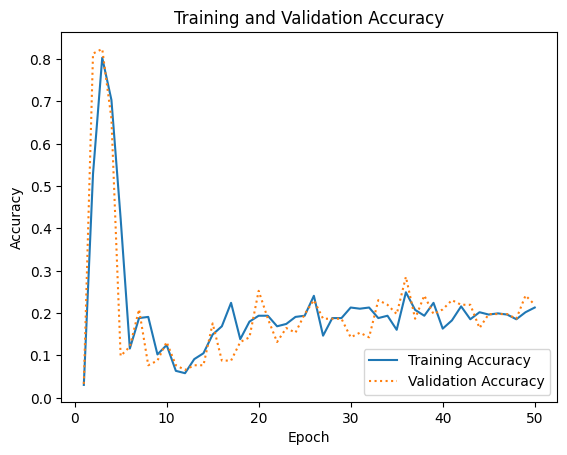

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()
plt.show()

In [ ]:
import glob
import os

def get_png_files(directory):
    folders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
    png_files = []

    for folder_name in folders:
        folder_path = os.path.join(directory, folder_name)
        if os.path.exists(folder_path):
            png_files.extend(glob.glob(os.path.join(folder_path, '*.png')))
        else:
            print(f"Folder '{folder_name}' does not exist in '{directory}'.")

    return png_files

directory_path = '/content/Output'
png_files_list = get_png_files(directory_path)

results = []
for file_path in png_files_list:
    x = image.load_img(file_path, target_size=(224, 224))

    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)

    y = model.predict(x)

    class_labels = ['belly pain','burping','discomfort','hungry','tired']

    # for i, label in enumerate(class_labels):
    #     print(f'{label}: {y[0][i]}')

    results.append(f"Original:{file_path.split('/')[3]} Predicted: {class_labels[np.argmax(y)]}")

print('\n')

for i in results:
    print(i)
    print('\n')

1/1 [==============================] - 0s 59ms/step


Original:belly_pain Predicted: hungry


Original:burping Predicted: burping


Original:discomfort Predicted: discomfort


Original:hungry Predicted: belly pain


Original:tired Predicted: tired


